In [67]:
from DataVisualisation import DataVisualisation
import ParametricalIdentification as pi
import pandas as pd
import numpy as np
import pandas as pd




In [68]:
import numpy as np

def numerical_derivative(func, x, h=1e-5):
    """
    Function to calculate derivative using finite difference method.

    Parameters:
    func (callable): Function to find derivative for.
    x (float or np.ndarray): Point(s) to calculate derivative at.
    h (float): Step for finite differences (default 1e-5).

    Returns:
    derivative: Derivative of function at point(s) x.
    """
    return (func(x + h) - func(x - h)) / (2 * h)
import numpy as np

def numerical_derivative_array(y, x):
    """
    Calculation of numerical derivate (central distribution)
    """
    dy = np.zeros_like(y)
    dy[1:-1] = (y[2:] - y[:-2]) / (x[2:] - x[:-2])
    dy[0] = (y[1] - y[0]) / (x[1] - x[0])
    dy[-1] = (y[-1] - y[-2]) / (x[-1] - x[-2])
    return dy




### Download data

In [69]:
# download data
import yfinance as yf
from DataPreparation import DataPreparation


url_gold = 'https://thedocs.worldbank.org/en/doc/18675f1d1639c7a34d463f59263ba0a2-0050012025/related/CMO-Historical-Data-Monthly.xlsx'
save_path_gold = 'data/gold_data.xlsx'

url_gpr = 'https://www.matteoiacoviello.com/gpr_files/data_gpr_export.xls' # Geopolitical Risk Index
save_path_grp = 'data/data_gpr_export.xls'

url_gld_us = 'https://www.spdrgoldshares.com/assets/dynamic/GLD/GLD_US_archive_EN.csv' # ETF Holdings (SPDR Gold Shares)
save_path_gld = 'data/GLD_US_archive_EN.csv'

url_debt_us = 'https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23ebf3fb&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1320&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=GFDEBTN&scale=left&cosd=1966-01-01&coed=2024-10-01&line_color=%230073e6&link_values=false&line_style=solid&mark_type=none&mw=3&lw=3&ost=-99999&oet=99999&mma=0&fml=a&fq=Quarterly%2C%20End%20of%20Period&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2025-05-24&revision_date=2025-05-24&nd=1966-01-01' # USA national debt
save_path_debt = 'data/debt_data.csv'

# Download VIX data for the last 5 years. SOURCE: #https://finance.yahoo.com/quote/%5EVIX/history/
debt = yf.Ticker("^VIX")
vix_data = debt.history(period="100y")

# Save data into csv
vix_data.to_csv("data/vix_data.csv")  

# Download DXY data for the last 100 years (if available)
# SOURCE: https://finance.yahoo.com/quote/DX-Y.NYB/history/
debt = yf.Ticker("DX-Y.NYB")
dxy_data = debt.history(period="100y")

# Save data into CSV
dxy_data.to_csv("data/dxy_data.csv")





dp = DataPreparation()

#dp.download_file(url_debt_us, save_path_debt)

dp.download_file(url_gpr, save_path_grp)

dp.download_file(url_gold, save_path_gold)

dp.download_file(url_gld_us, save_path_gld)





### Download CPI data

        Date  CPI
0 1913-01-01  9.8
1 1913-02-01  9.8
2 1913-03-01  9.8
3 1913-04-01  9.8
4 1913-05-01  9.7


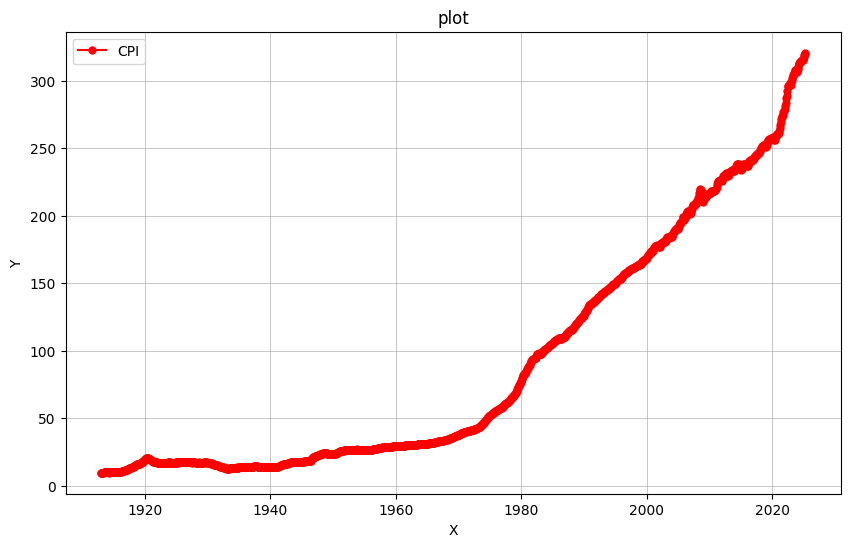

In [70]:
import pandas_datareader.data as web
from datetime import datetime

# SOURCE: https://www.bls.gov/cpi/data.htm
# Start date
start = datetime(1913, 1, 1)

# Download CPI (all goods, month, no season)
cpi = web.DataReader("CPIAUCNS", "fred", start)

# rename
cpi = cpi.rename(columns={"CPIAUCNS": "CPI"})

# turn index into column
cpi = cpi.reset_index()
cpi = cpi.rename(columns={"DATE": "Date"})



dv = DataVisualisation()
print(cpi.head())
cpi_plot = dv.plot_dataframe(cpi,'Date', 'CPI')
cpi_plot.show()

### Read GPR

       month        GPR       GPRH
0 1900-01-01  87.927849  87.927849
1 1900-02-01  86.566490  86.566490
2 1900-03-01  72.140701  72.140701
3 1900-04-01  54.419449  54.419449
4 1900-05-01  64.405197  64.405197


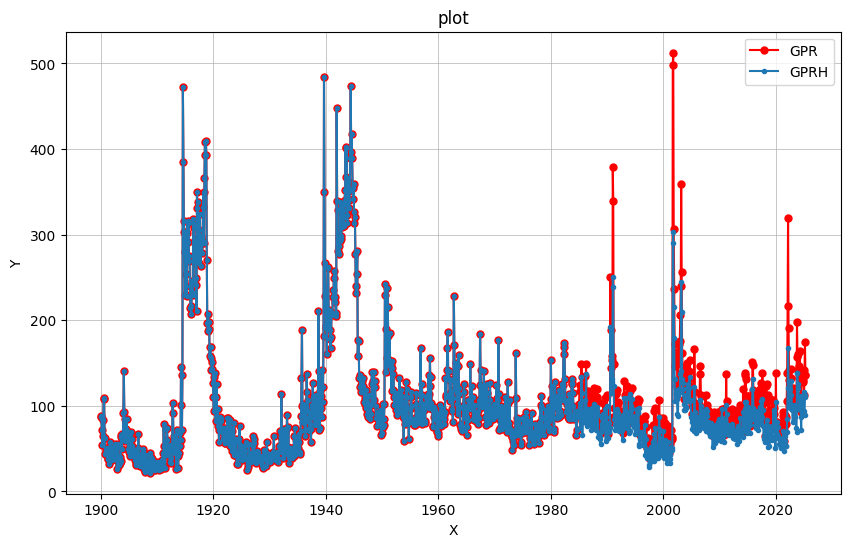

In [71]:
# read xlsx as pandas dataframe
gpr = pd.read_excel(save_path_grp, usecols=[0,1,4])
gpr["GPR"] = gpr["GPR"].fillna(gpr["GPRH"])
print(gpr.head())
dv = DataVisualisation()
gpr_plot = dv.plot_dataframe(gpr,'month', 'GPR',else_y_cols=['GPRH'])
gpr_plot.show()

gpr = gpr[["month","GPR"]]


### Read ETF Holdings (SPDR Gold Shares) data

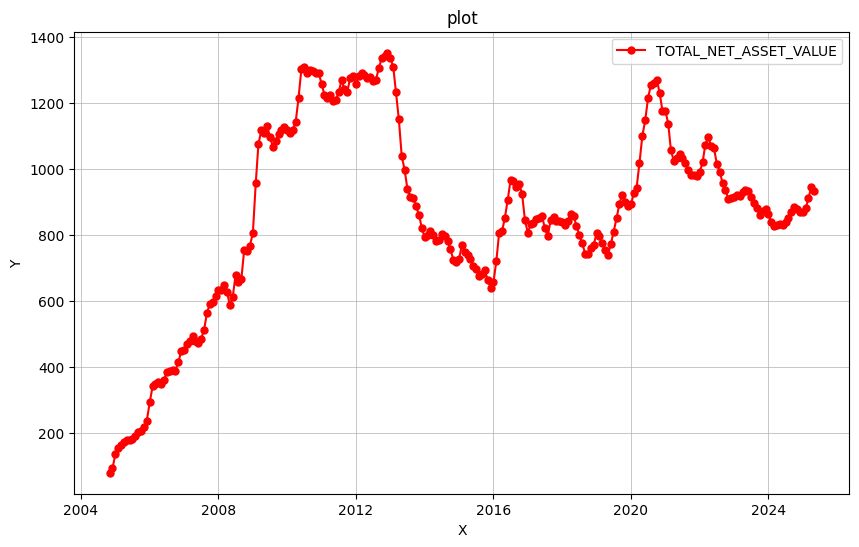

In [72]:
# read csv as pandas dataframe
gld = pd.read_csv(
    save_path_gld,
    parse_dates=["Date"],
    dayfirst=True,
    na_values=["HOLIDAY"]
)

# Remove extra spaces in column headers
gld.columns = gld.columns.str.strip()

# Rename the required column
gld = gld.rename(columns={
    "Total Net Asset Value Tonnes in the Trust as at 4.15 p.m. NYT": "TOTAL_NET_ASSET_VALUE"
})

# Convert the column to numeric type
gld["TOTAL_NET_ASSET_VALUE"] = pd.to_numeric(gld["TOTAL_NET_ASSET_VALUE"], errors="coerce")

# Remove rows with NaN values
gld = gld.dropna(subset=["TOTAL_NET_ASSET_VALUE"])

# Keep only the necessary columns
gld = gld[["Date", "TOTAL_NET_ASSET_VALUE"]]

# Add a month column
gld["Month"] = gld["Date"].dt.to_period("M")

# Calculate the monthly average
monthly_avg = gld.groupby("Month")["TOTAL_NET_ASSET_VALUE"].mean().reset_index()
monthly_avg["Month"] = monthly_avg["Month"].dt.to_timestamp()
gld = monthly_avg
dv = DataVisualisation()

# Plot the data
debt_plot = dv.plot_dataframe(gld, 'Month', 'TOTAL_NET_ASSET_VALUE')
debt_plot.show()

### Read VIX data

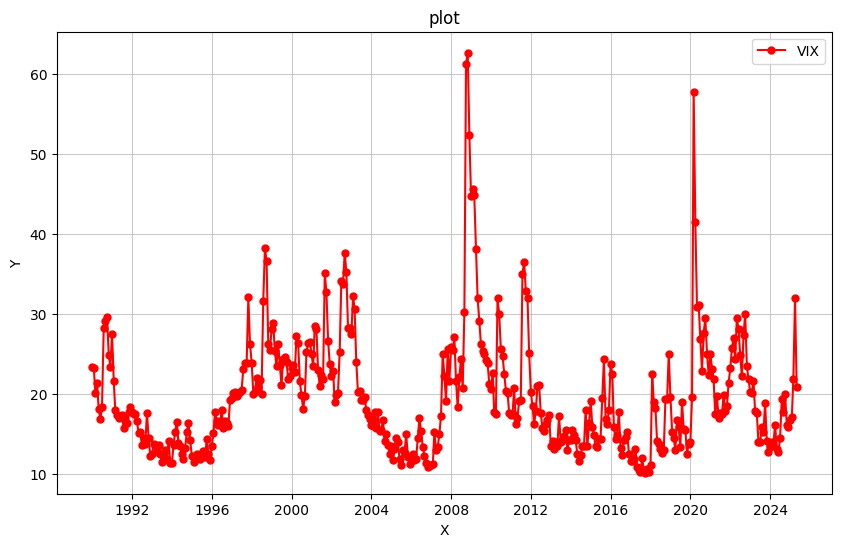

In [73]:

# Step 1: Read CSV
vix = pd.read_csv("data/vix_data.csv")

# Step 2: Clean column names
vix.columns = vix.columns.str.strip()

# Step 3: Rename "Close" column to "VIX"
vix = vix.rename(columns={"Close": "VIX"})

# Step 4: Convert Date to datetime with utc=True, then drop timezone
vix["Date"] = pd.to_datetime(vix["Date"], errors="coerce", utc=True)
vix["Date"] = vix["Date"].dt.tz_convert(None)

# Step 5: Convert VIX to numeric
vix["VIX"] = pd.to_numeric(vix["VIX"], errors="coerce")

# Step 6: Remove rows with missing data
vix = vix.dropna(subset=["Date", "VIX"])

# Step 7: Keep only relevant columns
vix = vix[["Date", "VIX"]]

# Step 8: Add "Month" column and calculate monthly average
vix["Month"] = vix["Date"].dt.to_period("M")
monthly_avg = vix.groupby("Month")["VIX"].mean().reset_index()
monthly_avg["Month"] = monthly_avg["Month"].dt.to_timestamp()
vix = monthly_avg
# Step 9: Plot
dv = DataVisualisation()
vix_plot = dv.plot_dataframe(monthly_avg, 'Month', 'VIX')
vix_plot.show()


### Read dxy data

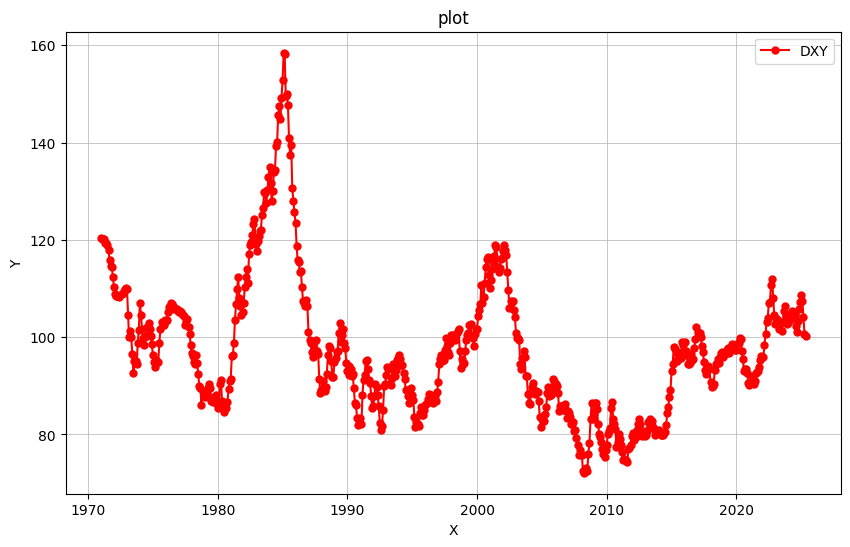

In [74]:

# Step 1: Read CSV
dxy = pd.read_csv("data/dxy_data.csv")

# Step 2: Clean column names
dxy.columns = dxy.columns.str.strip()

# Step 3: Rename "Close" column to "DXY"
dxy = dxy.rename(columns={"Close": "DXY"})

# Step 4: Convert Date to datetime with utc=True, then drop timezone
dxy["Date"] = pd.to_datetime(dxy["Date"], errors="coerce", utc=True)
dxy["Date"] = dxy["Date"].dt.tz_convert(None)

# Step 5: Convert DXY to numeric
dxy["DXY"] = pd.to_numeric(dxy["DXY"], errors="coerce")

# Step 6: Remove rows with missing data
dxy = dxy.dropna(subset=["Date", "DXY"])

# Step 7: Keep only relevant columns
dxy = dxy[["Date", "DXY"]]

# Step 8: Add "Month" column and calculate monthly average
dxy["Month"] = dxy["Date"].dt.to_period("M")
monthly_avg = dxy.groupby("Month")["DXY"].mean().reset_index()
monthly_avg["Month"] = monthly_avg["Month"].dt.to_timestamp()

dxy = monthly_avg

# Step 9: Plot
dv = DataVisualisation()
debt_plot = dv.plot_dataframe(monthly_avg, 'Month', 'DXY')
debt_plot.show()


### Read gold data

          Date     Gold
85  1967-01-01    34.95
86  1967-02-01    34.95
87  1967-03-01    34.95
88  1967-04-01    34.95
89  1967-05-01    34.95
..         ...      ...
780 2024-12-01  2648.01
781 2025-01-01  2709.69
782 2025-02-01  2894.73
783 2025-03-01  2983.25
784 2025-04-01  3217.64

[700 rows x 2 columns]


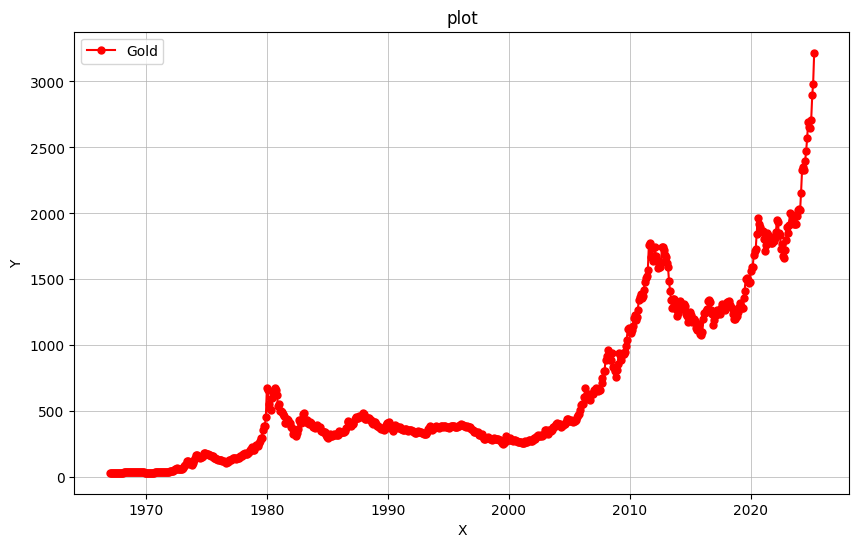

In [75]:

gold = pd.read_excel(
    "data/gold_data.xlsx",
    sheet_name="Monthly Prices",
    skiprows=4 
)

# Rename columns
gold = gold.rename(columns={"Unnamed: 0": "Date"})
gold = gold.rename(columns={"Gold": "Gold"})
gold = gold[['Date','Gold']]
gold = gold.drop(index=0) 
# Convert Date to datetime
gold["Date"] = pd.to_datetime(gold["Date"].str.replace("M", "-") + "-01")

# Filter data from 1967 onward
gold = gold[gold["Date"] >= pd.to_datetime("1967-01-01")]

print(gold)

dv = DataVisualisation()
debt_plot = dv.plot_dataframe(gold, 'Date', 'Gold')
debt_plot.show()

### Read debt data

        Date           Debt
0 1966-01-01  320999.000000
1 1966-02-01  319365.000000
2 1966-03-01  317731.000000
3 1966-04-01  316097.000000
4 1966-05-01  318980.666667


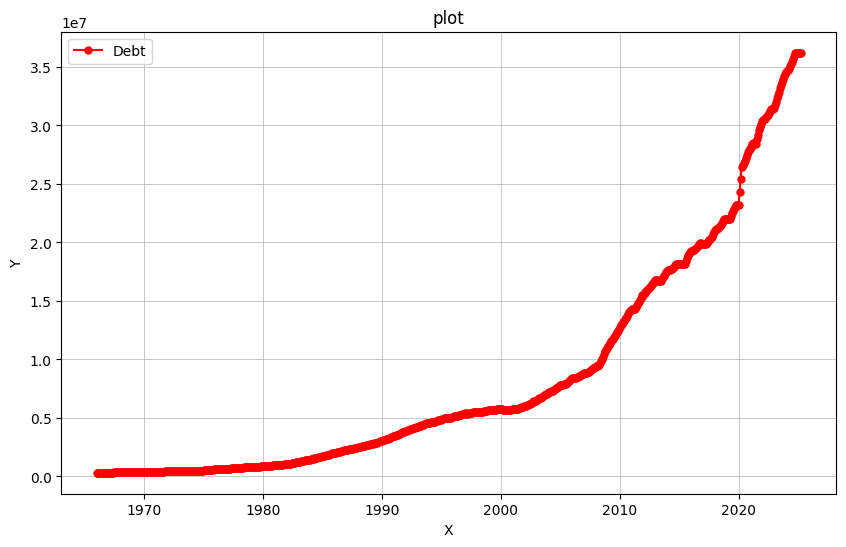

In [76]:
# Step 1: Read CSV
debt = pd.read_csv("data/debt_data.csv")

# Step 2: Clean column names
debt.columns = debt.columns.str.strip()

# Step 3: Rename columns
debt = debt.rename(columns={"observation_date": "Date"})
debt = debt.rename(columns={"GFDEBTN": "Debt"})


# Step 4: Convert Date to datetime with utc=True, then drop timezone
debt["Date"] = pd.to_datetime(debt["Date"], errors="coerce", utc=True)
debt["Date"] = debt["Date"].dt.tz_convert(None)


# Step 8: Add "Month" column and calculate monthly average
debt["Month"] = debt["Date"].dt.to_period("M")
monthly_avg = debt.groupby("Month")["Debt"].mean().reset_index()
monthly_avg["Month"] = monthly_avg["Month"].dt.to_timestamp()
debt = monthly_avg

# Step 9: Create full monthly date range
full_months = pd.date_range(start=debt["Month"].min(), end=debt["Month"].max(), freq='MS')
full_df = pd.DataFrame({"Month": full_months})

# Step 10: Merge with existing data
debt = pd.merge(full_df, debt, on="Month", how="left")

# Step 11: Forward fill to fill missing months with previous quarter value
debt_interpolated = debt
debt_interpolated["Debt"] = debt["Debt"].interpolate(method="linear")
debt_interpolated = debt_interpolated.rename(columns={"Month": "Date"})

debt["Debt"] = debt["Debt"].ffill()
print(debt_interpolated.head())
# Step 12: Plot again
dv = DataVisualisation()
debt_plot = dv.plot_dataframe(debt_interpolated, 'Date', 'Debt')
debt_plot.show()


### Unite data frames

In [77]:
"""
print(debt.head())
print(gold.head())
print(vix.head())
print(dxy.head())
print(gld.head())
print(gpr.head())
print(cpi.head())
"""
# Step 1: Rename date columns to a common name
debt = debt.rename(columns={"Month": "Date"})
vix = vix.rename(columns={"Month": "Date"})
dxy = dxy.rename(columns={"Month": "Date"})
gld = gld.rename(columns={"Month": "Date"})
gpr = gpr.rename(columns={"month": "Date"})  # already datetime
cpi = cpi.rename(columns={"Date": "Date"})
gold = gold.rename(columns={"Date": "Date"})

# Step 2: Ensure all 'Date' columns are datetime
for df in [debt, vix, dxy, gld, gpr, cpi, gold]:
    df["Date"] = pd.to_datetime(df["Date"], errors='coerce')

# Step 3: Merge all dataframes on the 'Date' column using outer join
merged = debt.copy()
merged = merged.merge(gold, on="Date", how="outer")
merged = merged.merge(vix, on="Date", how="outer")
merged = merged.merge(dxy, on="Date", how="outer")
merged = merged.merge(gld, on="Date", how="outer")
merged = merged.merge(gpr, on="Date", how="outer")
merged = merged.merge(cpi, on="Date", how="outer")

# Step 4: Sort the combined dataframe by date
merged = merged.sort_values("Date").reset_index(drop=True)

# Step 5: Keep only rows where gold price is not NaN
merged = merged[merged["Gold"].notna()].reset_index(drop=True)

print(merged.head())  # Inspect merged result


merged.to_csv("data/merged_filtered_data.csv", index=False)




        Date           Debt   Gold  VIX  DXY  TOTAL_NET_ASSET_VALUE  \
0 1967-01-01  330947.000000  34.95  NaN  NaN                    NaN   
1 1967-02-01  328262.333333  34.95  NaN  NaN                    NaN   
2 1967-03-01  325577.666667  34.95  NaN  NaN                    NaN   
3 1967-04-01  322893.000000  34.95  NaN  NaN                    NaN   
4 1967-05-01  327227.333333  34.95  NaN  NaN                    NaN   

          GPR   CPI  
0   78.875809  32.9  
1   93.530823  32.9  
2  106.475494  33.0  
3   86.284355  33.1  
4  124.016533  33.2  


Index(['year', 'Gold', 'Debt', 'Gold_exponent', 'Debt_polynomial',
       'Debt_poly_deriv', 'Gold_exponent_deriv'],
      dtype='object')


C:\Users\ieand\AppData\Local\Temp\ipykernel_8388\1717509579.py:32: RuntimeWarning: invalid value encountered in power
  merged_df['Debt_poly_deriv'] = numerical_derivative(lambda x: popt_debt[0]*x**popt_debt[1] + popt_debt[2],x_year)


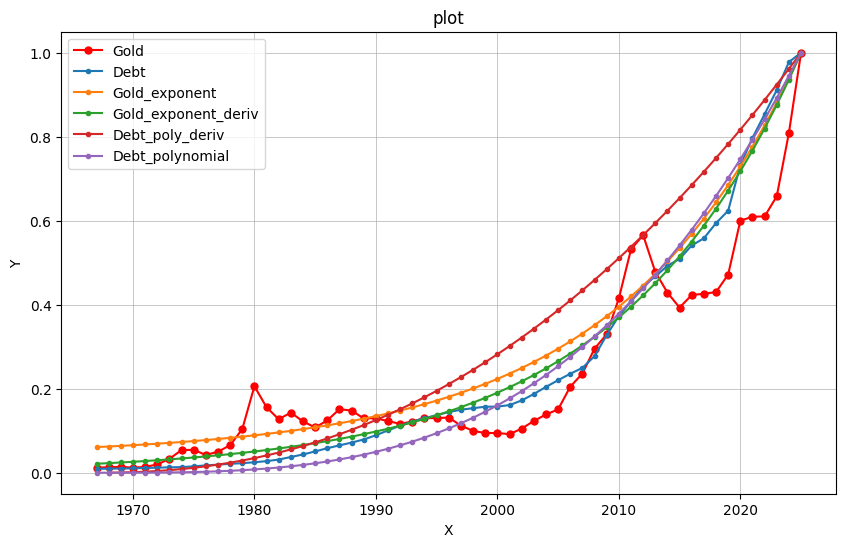

In [78]:
# --- Data Preparation ---
h_gold_price = merged[['Date', 'Gold']].dropna()  # Handle NaNs
debt_interpolated = debt_interpolated.dropna()  # Handle NaNs
debt_interpolated['year'] = debt_interpolated['Date'].dt.year
h_gold_price['year'] = h_gold_price['Date'].dt.year

# Grouping data by year and calculating the average
yearly_avg_gold = h_gold_price.groupby('year')['Gold'].mean().reset_index()
yearly_avg_debt = debt_interpolated.groupby('year')['Debt'].mean().reset_index()

merged_df = pd.merge(yearly_avg_gold, yearly_avg_debt, on='year', how='outer').dropna()
merged_df = merged_df.sort_values('year')

# --- Curve Fitting ---
x_year = merged_df['year'].values - merged_df['year'].min()  # Normalize x-axis

# Initial guesses (these might need adjustment)
initial_guess_gold = [50, 0.05, 100]
initial_guess_debt = [67,3,400]
# Fit gold prices
popt_gold= pi.general_least_squares_fit(x_year, merged_df['Gold'].values, pi.exponential_func, initial_guess_gold,'exponent', epsilon=1e-6, max_iter=500)
merged_df['Gold_exponent'] = pi.exponential_func(x_year, *popt_gold)
# Fit USD debt
popt_debt = pi.general_least_squares_fit(x_year, merged_df['Debt'].values, pi.polynomial_func, initial_guess_debt, 'polynomial', epsilon=1e-6, max_iter=500)
merged_df['Debt_polynomial'] = pi.polynomial_func(x_year, *popt_debt)

# --- Analytical Derivative ---
# Derivative of a*exp(b*x) is a*b*exp(b*x)
def exponential_derivative(x, a, b,c):
    return a * b * np.exp(b * x)

merged_df['Debt_poly_deriv'] = numerical_derivative(lambda x: popt_debt[0]*x**popt_debt[1] + popt_debt[2],x_year)
merged_df['Gold_exponent_deriv'] = exponential_derivative(x_year, popt_gold[0], popt_gold[1], popt_gold[2])

# --- Normalization ---
merged_df['Gold'] = merged_df['Gold'] / merged_df['Gold'].max()
merged_df['Debt'] = merged_df['Debt'] / merged_df['Debt'].max()
merged_df['Gold_exponent'] = merged_df['Gold_exponent'] / merged_df['Gold_exponent'].max()
merged_df['Debt_polynomial'] = merged_df['Debt_polynomial'] / merged_df['Debt_polynomial'].max()
merged_df['Debt_poly_deriv'] = merged_df['Debt_poly_deriv'] / merged_df['Debt_poly_deriv'].max()
merged_df['Gold_exponent_deriv'] = merged_df['Gold_exponent_deriv'] / merged_df['Gold_exponent_deriv'].max()

# --- Plotting ---
print(merged_df.columns)
debt_plot = dv.plot_dataframe(merged_df,'year', 'Gold',else_y_cols=['Debt','Gold_exponent', 'Gold_exponent_deriv','Debt_poly_deriv','Debt_polynomial'])
debt_plot.show()


#### Constructing Debt_poly_deriv 

In [ ]:


# --- Monthly Index Construction ---
start_year = merged_df['year'].min()  # например, 1970
monthly_df = pd.date_range(start=h_gold_price['Date'].min(), end=h_gold_price['Date'].max(), freq='MS')
monthly_df = pd.DataFrame({'month': monthly_df})

monthly_df['index_month'] = (monthly_df['month'].dt.year - start_year + 1) + (monthly_df['month'].dt.month - 1) / 12.0

# --- Apply fitted models ---
monthly_df['Gold_exponent'] = pi.exponential_func(monthly_df['index_month'], *popt_gold)
monthly_df['Debt_polynomial'] = pi.polynomial_func(monthly_df['index_month'], *popt_debt)

# --- Derivatives ---

monthly_df['Gold_exponent_deriv'] = exponential_derivative(monthly_df['index_month'], popt_gold[0], popt_gold[1], popt_gold[2])
monthly_df['Debt_poly_deriv'] = numerical_derivative(
    lambda x: popt_debt[0] * x**popt_debt[1] + popt_debt[2], monthly_df['index_month']
)

monthly_df = monthly_df.rename(columns={'month': 'Date'})


[4.95454868e+01 6.63227492e-02 9.80771099e+01]


#### Merge results and calculate gold derivation

In [80]:
# merge DataFrames by 'Date'
merged = pd.merge(merged, monthly_df[['Date', 'Debt_poly_deriv']], on='Date', how='left')
# Generate x as index
x = np.arange(len(merged))
y = merged['Gold'].values

# Calculate deriv and add to dataframe
merged['Gold_deriv'] = numerical_derivative_array(y, x)


In [85]:
import FuzzyLogic as fl
merged = merged.dropna()

print(merged.head())

import math

# 1. DEBT — плавний ріст, стабільна структура → сигмоїдна
debt_variable = fl.FuzzyLinguisticVariable("Debt", (3_000_000, 35_000_000))
debt_variable.add_term(fl.FuzzyTerm("Low", fl.sigmoid_function(-0.000001, 18_000_000)))
debt_variable.add_term(fl.FuzzyTerm("High", fl.sigmoid_function(0.000001, 18_000_000)))

# 2. VIX — різкі коливання, високі стрибки → Z-shaped
vix_variable = fl.FuzzyLinguisticVariable("VIX", (10, 60))
vix_variable.add_term(fl.FuzzyTerm("Low", fl.z_shape_function(10, 25)))
vix_variable.add_term(fl.FuzzyTerm("High", fl.z_shape_function(25, 60, inverse=True)))

# 3. DXY — стабільна, але зі зсувами → трикутна
dxy_variable = fl.FuzzyLinguisticVariable("DXY", (70, 120))
dxy_variable.add_term(fl.FuzzyTerm("Low", fl.triangle_function(70, 85, 95)))
dxy_variable.add_term(fl.FuzzyTerm("High", fl.triangle_function(95, 105, 120)))

# 4. TOTAL_NET_ASSET_VALUE — помірна мінливість → трапецієподібна
asset_variable = fl.FuzzyLinguisticVariable("TOTAL_NET_ASSET_VALUE", (0, 300))
asset_variable.add_term(fl.FuzzyTerm("Low", fl.trapezoidal_function(0, 0, 70, 120)))
asset_variable.add_term(fl.FuzzyTerm("High", fl.trapezoidal_function(180, 230, 300, 300)))

# 5. GPR — ризик змінюється стрибками → трикутна
gpr_variable = fl.FuzzyLinguisticVariable("GPR", (50, 200))
gpr_variable.add_term(fl.FuzzyTerm("Low", fl.triangle_function(50, 100, 125)))
gpr_variable.add_term(fl.FuzzyTerm("High", fl.triangle_function(125, 160, 200)))

# 6. Debt_poly_deriv — плавний ріст → сигмоїдна
debt_deriv_variable = fl.FuzzyLinguisticVariable("Debt_poly_deriv", (0, 1_000_000))
debt_deriv_variable.add_term(fl.FuzzyTerm("Low", fl.sigmoid_function(-0.00001, 500_000)))
debt_deriv_variable.add_term(fl.FuzzyTerm("High", fl.sigmoid_function(0.00001, 500_000)))

# 7. Gold_deriv — спад або ріст з центром у 0 → гаусова
gold_deriv_variable = fl.FuzzyLinguisticVariable("Gold_deriv", (-20, 20))
gold_deriv_variable.add_term(fl.FuzzyTerm("Low", fl.gaussian_function(-10, 5)))
gold_deriv_variable.add_term(fl.FuzzyTerm("High", fl.gaussian_function(10, 5)))



          Date          Debt     Gold        VIX        DXY  \
454 2004-11-01  7.656408e+06  439.375  13.577143  83.598182   
455 2004-12-01  7.716674e+06  442.079  12.459545  81.569130   
456 2005-01-01  7.776939e+06   424.03  13.438000  83.111905   
457 2005-02-01  7.796791e+06   423.35  11.708947  83.723500   
458 2005-03-01  7.816644e+06   433.85  13.126364  82.836363   

     TOTAL_NET_ASSET_VALUE         GPR    CPI  Debt_poly_deriv Gold_deriv  
454              80.517500  122.707390  191.0    806411.074940    10.8075  
455              93.319524  109.895226  190.3    810301.186610    -7.6725  
456             136.678000  100.887589  190.7    814201.682713    -9.3645  
457             155.104211  108.977966  191.8    818112.568650       4.91  
458             163.344091   90.410484  193.3    822033.850197     2.9415  


In [89]:
# Create a dictionary of the linguistic variables
from FuzzyLogic import HistoricalFuzzyRuleBase, generate_all_rules


variables_dict = {
    "Debt": debt_variable,
    "VIX": vix_variable,
    "DXY": dxy_variable,
    "TOTAL_NET_ASSET_VALUE": asset_variable,
    "GPR": gpr_variable,
    "Debt_poly_deriv": debt_deriv_variable,
    "Gold_deriv": gold_deriv_variable,
}

# Generate all possible fuzzy rules
all_variables = list(variables_dict.values())
rules = generate_all_rules(all_variables)

# Create the historical fuzzy rule base
rule_base = HistoricalFuzzyRuleBase(variables_dict)
for rule in rules:
    rule_base.add_rule(rule)

# Create some historical data (replace with your actual data)
data = {
    "Debt": [5_000_000, 15_000_000, 25_000_000, 10_000_000, 30_000_000],
    "VIX": [20, 35, 15, 45, 25],
    "DXY": [90, 100, 85, 110, 95],
    "TOTAL_NET_ASSET_VALUE": [100, 200, 50, 250, 150],
    "GPR": [110, 130, 90, 150, 120],
    "Debt_poly_deriv": [100_000, 600_000, 200_000, 800_000, 400_000],
    "Gold_deriv": [-5, 3, 8, -2, 6],
    "Gold_Price": [1800, 1850, 1780, 1900, 1820],  # Target variable
}
df = pd.DataFrame(data)

# Prepare training data
input_data_list = df[[col for col in df.columns if col != "Gold_Price"]].to_dict('records')
targets = df["Gold_Price"].tolist()

# Train the fuzzy rule base
rule_base.train(input_data_list, targets)

# Prepare input for prediction
new_data = {
    "Debt": merged["Debt"].iloc[-1],
    "VIX": merged["VIX"].iloc[-1],
    "DXY": merged["DXY"].iloc[-1],
    "TOTAL_NET_ASSET_VALUE": merged["TOTAL_NET_ASSET_VALUE"].iloc[-1],
    "GPR": merged["GPR"].iloc[-1],
    "Debt_poly_deriv": merged["Debt_poly_deriv"].iloc[-1],  # Исправленное название
    "Gold_deriv": merged["Gold_deriv"].iloc[-1],
}

# Predict the gold price
predicted_price = rule_base.predict(new_data)
print(f"\nPredicted Gold Price: {predicted_price:.2f}")
print(merged["Gold"])

Rule [('Debt', 'Low'), ('VIX', 'Low'), ('DXY', 'Low'), ('TOTAL_NET_ASSET_VALUE', 'Low'), ('GPR', 'Low'), ('Debt_poly_deriv', 'Low'), ('Gold_deriv', 'Low')] → coeffs: [ 5.68437241e-05 -1.08447912e+02  8.59989054e+01  1.09239803e+00
  1.48643447e+01 -1.91518567e-03  1.10042866e+02 -5.22238837e+03]
Rule [('Debt', 'Low'), ('VIX', 'Low'), ('DXY', 'Low'), ('TOTAL_NET_ASSET_VALUE', 'Low'), ('GPR', 'Low'), ('Debt_poly_deriv', 'Low'), ('Gold_deriv', 'High')] → coeffs: [ 5.02883538e-04  1.80092015e+02 -2.01877834e+02 -1.29883252e+01
  8.39816635e+00  4.83910045e-03 -2.42174716e+02  8.78338552e+03]
Rule [('Debt', 'Low'), ('VIX', 'Low'), ('DXY', 'Low'), ('TOTAL_NET_ASSET_VALUE', 'Low'), ('GPR', 'Low'), ('Debt_poly_deriv', 'High'), ('Gold_deriv', 'Low')] → coeffs: [ 7.98562536e-05  3.31455765e+02 -9.06198054e+01 -1.48084250e+01
  6.91688931e+01 -1.12255462e-03  5.40729516e+01  1.01193061e+03]
Rule [('Debt', 'Low'), ('VIX', 'Low'), ('DXY', 'Low'), ('TOTAL_NET_ASSET_VALUE', 'Low'), ('GPR', 'Low'), ('